In [5]:
import math
import torch

model = torch.load("../models/neuralforecast_models/AutoAutoformer_0.ckpt")
# 获取权重
Wq = model['state_dict']['encoder.attn_layers.1.attention.query_projection.weight'].data
Wk = model['state_dict']['encoder.attn_layers.1.attention.key_projection.weight'].data
Wv = model['state_dict']['encoder.attn_layers.1.attention.value_projection.weight'].data

In [6]:
import torch
import torch.nn.functional as F
import seaborn as sns


def compute_attention(time_series, Wq, Wk, Wv, plot=True, top_k=6):
    Q = torch.matmul(time_series, Wq)
    K = torch.matmul(time_series, Wk)
    V = torch.matmul(time_series, Wv)

    attention_scores = torch.matmul(Q, K.T) / math.sqrt(K.size(-1))
    attention_weights = F.softmax(attention_scores, dim=-1)  # Apply softmax to normalize
    attention = torch.matmul(attention_weights, V)

    # Setup the plot
    if plot:
        fig, axs = plt.subplots(2, 1, figsize=(12, 6), gridspec_kw={'height_ratios': [3, 1]})

        # Time series plot
        axs[0].plot(time_series.T, '-', label='Time Series')
        axs[0].set_title('Time Series')
        axs[0].set_xlabel('Time Step')
        axs[0].set_ylabel('Value')
        axs[0].legend()

        top_attention, top_indices = torch.topk(attention, top_k, dim=1)  # Get top-k attention scores and indices
        for idx in top_indices[0]:  # Assuming single batch; adjust if multiple batches
            axs[0].axvline(x=idx.item(), color='r', linestyle='dashdot', lw=0.5,
                           label=f'High Attention (Step {idx.item()})')

        # Attention weights heatmap
        sns.heatmap(attention, ax=axs[1], cbar=True)
        axs[1].set_title('Attention Weights')
        axs[1].set_xlabel('Time Step')
        axs[1].set_ylabel('Attention')
        axs[1].xaxis.set_ticks_position('top')  # Move x-axis to top to align with time series plot

        plt.tight_layout()
        plt.show()

    return attention

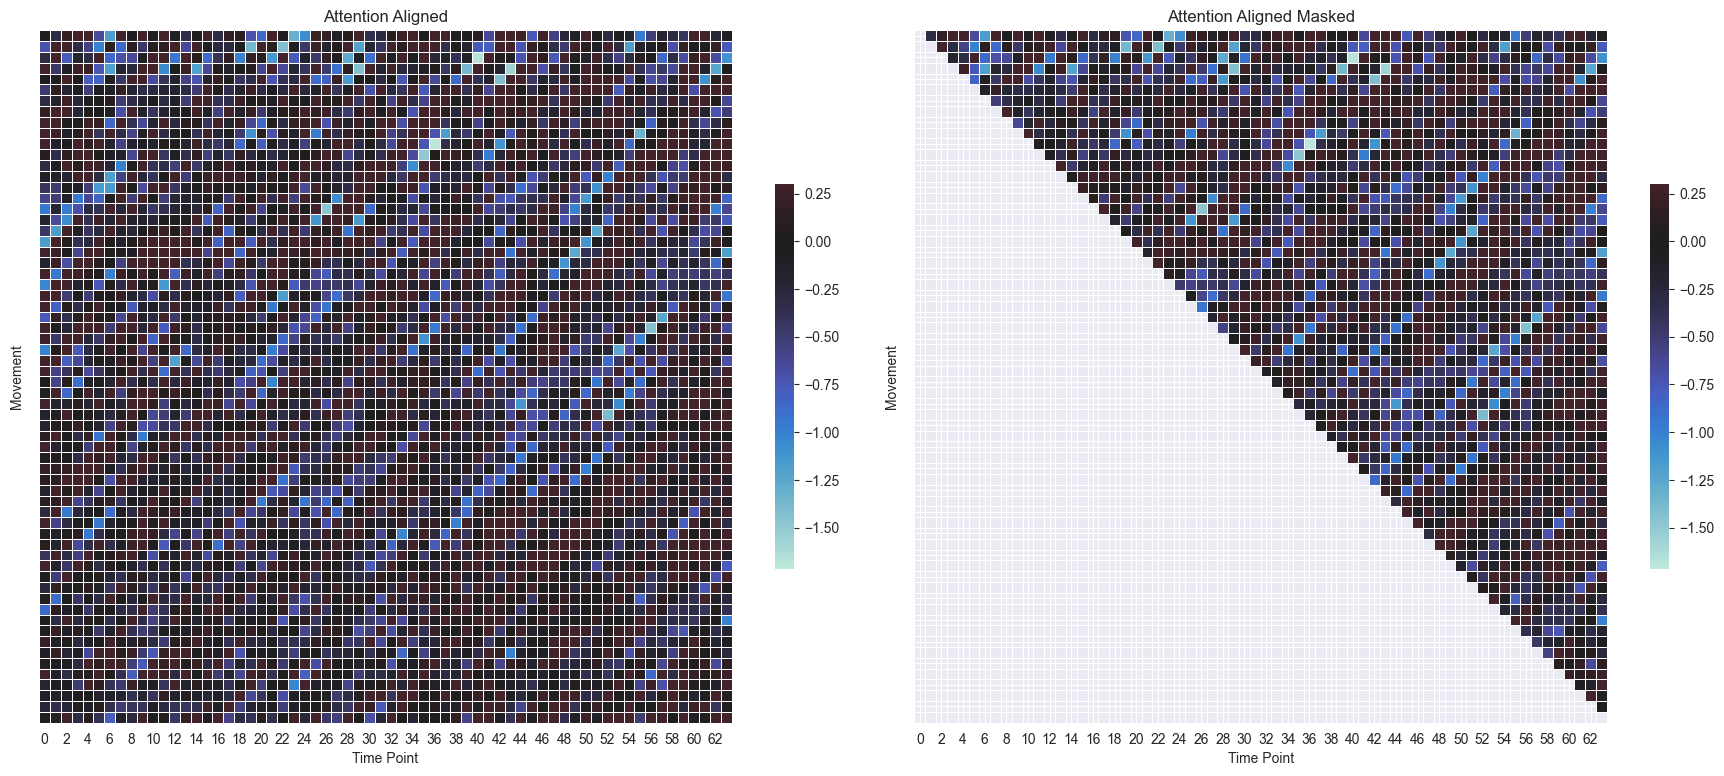

In [7]:
import numpy as np
import pandas as pd
from sqlalchemy import create_engine
from sklearn.preprocessing import RobustScaler
from matplotlib import pyplot as plt

# database_url = "sqlite:////content/data.sqlite"
database_url = "sqlite:///../data/data.sqlite"
engine = create_engine(database_url)
# 从数据库读取数据
query = "select date as ds, global_entry from sh_visitors_daily"
df = pd.read_sql_query(query, engine, index_col='ds', parse_dates=['ds'])

attns = []
n = 1000
multiplier = 1
for i in range(64):
    selected_data = df.iloc[n + i * multiplier:n + i * multiplier + 64]
    robust_scaler = RobustScaler()
    robust_scaled_data = robust_scaler.fit_transform(selected_data.values)
    attn = compute_attention(torch.tensor(robust_scaled_data).type(torch.float).T, Wq, Wk, Wv, plot=False)
    attns.append(torch.squeeze(attn).tolist())

attns = np.array(attns)

# 每行向左移动i位
for i in range(attns.shape[0]):
    attns[i] = np.roll(attns[i], -i)

# 创建遮盖右上部分的掩码
# 矩阵的水平翻转
# flipped_data = np.fliplr(np.ones_like(attns, dtype=bool))
# 提取下三角部分，包含对角线
mask = np.tril(flipped_data)
# 再次水平翻转回来以符合原始方向
# mask  = np.fliplr(lower_triangle)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 8))  # 1行2列
# Draw the heatmap with the mask and correct aspect ratio
a = sns.heatmap(attns, vmax=.3, center=0,
                square=True, linewidths=.5, cbar_kws={"shrink": .5}, ax=ax1)
a.set_yticklabels([])
a.yaxis.set_ticks_position('none')
ax1.set_title('Attention Aligned')
ax1.set_xlabel('Time Point')
ax1.set_ylabel('Movement')

a = sns.heatmap(attns, mask=mask, vmax=.3, center=0,
                square=True, linewidths=.5, cbar_kws={"shrink": .5}, ax=ax2)
a.set_yticklabels([])
a.yaxis.set_ticks_position('none')
ax2.set_title('Attention Aligned Masked')
ax2.set_xlabel('Time Point')
ax2.set_ylabel('Movement')


plt.tight_layout()
plt.show()


In [8]:
import matplotlib.pyplot as plt

# 示例数据
list1 = list(robust_scaled_data)
list2 = attn.tolist()

# 初始化画图
plt.figure(figsize=(10, 5))

# 上一个颜色变换点
last_change = 0
current_color = 'green' if list2[0] > 0 else 'red'

# 循环遍历，绘制每个段落
for i in range(1, len(list1)):
    # 如果符号改变了
    if (list2[i] > 0 >= list2[i - 1]) or (list2[i] <= 0 < list2[i - 1]):
        # 绘制前一段，包括当前点，以确保连贯
        plt.plot(range(last_change, i + 1), list1[last_change:i + 1], color=current_color)
        # 更新颜色和变化点
        current_color = 'green' if list2[i] > 0 else 'red'
        last_change = i

# 绘制最后一段
plt.plot(range(last_change, len(list1)), list1[last_change:], color=current_color)

# 添加图例和标题
plt.title('Line Plot with Color Change Based on Second List')
plt.xlabel('Index')
plt.ylabel('Value')

# 显示图形
plt.show()


TypeError: '>' not supported between instances of 'list' and 'int'

<Figure size 1000x500 with 0 Axes>